In [2]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import tensorflow as tf
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [3]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    import keras
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
        
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+'2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = keras.layers.add([X,X_shortcut])
    X = Activation('relu')(X)
        
    return X

In [4]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.19716813 0.         1.3561227  2.1713073  0.         1.3324987 ]


In [5]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    import keras
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)   
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1,1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)  
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', 
               kernel_initializer=glorot_uniform(seed=0))(X_shortcut)    
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = keras.layers.add([X,X_shortcut])
    X = Activation('relu')(X)
        
    return X

In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.09018463 1.2348977  0.46822017 0.0367176  0.         0.65516603]


In [7]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    print(X.shape)
    print(1)
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    print(X.shape)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    print(X.shape)
    X = Activation('relu')(X)
    print(X.shape)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    print(X.shape)
    print(2)
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    print(X.shape)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    print(X.shape)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    print(X.shape)
    ### START CODE HERE ###
    print(3)
    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    print(X.shape)
    X = identity_block(X,3,[128,128,512],stage=3,block='b')
    print(X.shape)
    X = identity_block(X,3,[128,128,512],stage=3,block='c')
    print(X.shape)
    X = identity_block(X,3,[128,128,512],stage=3,block='d')
    print(X.shape)
    print(4)
    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256,256,1024], stage = 4, block='a', s = 2)
    print(X.shape)
    X = identity_block(X,3,[256,256,1024],stage=4,block='b')
    print(X.shape)
    X = identity_block(X,3,[256,256,1024],stage=4,block='c')
    print(X.shape)
    X = identity_block(X,3,[256,256,1024],stage=4,block='d')
    print(X.shape)
    X = identity_block(X,3,[256,256,1024],stage=4,block='e')
    print(X.shape)
    X = identity_block(X,3,[256,256,1024],stage=4,block='f')
    print(X.shape)
    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512,512,2048], stage = 5, block='a', s = 2)
    print(X.shape)
    X = identity_block(X,3,[512,512,2048],stage=5,block='b')
    print(X.shape)
    X = identity_block(X,3,[512,512,2048],stage=5,block='c')
    print(X.shape)
    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2),strides=None, padding='valid', data_format=None)(X)
    print(X.shape)
    ### END CODE HERE ###
    print("flatten")
    # output layer
    X = Flatten()(X)
    print(X.shape)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    print(X.shape)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [8]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

(?, 70, 70, 3)
1
(?, 32, 32, 64)
(?, 32, 32, 64)
(?, 32, 32, 64)
(?, 15, 15, 64)
2
(?, 15, 15, 256)
(?, 15, 15, 256)
(?, 15, 15, 256)
3
(?, 8, 8, 512)
(?, 8, 8, 512)
(?, 8, 8, 512)
(?, 8, 8, 512)
4
(?, 4, 4, 1024)
(?, 4, 4, 1024)
(?, 4, 4, 1024)
(?, 4, 4, 1024)
(?, 4, 4, 1024)
(?, 4, 4, 1024)
(?, 2, 2, 2048)
(?, 2, 2, 2048)
(?, 2, 2, 2048)
(?, 1, 1, 2048)
flatten
(?, ?)
(?, 6)


In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
import h5py
def load_dataset():

    train_dataset = h5py.File('Downloads/train_signs.h5', "r")

    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features

    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels



    test_dataset = h5py.File('Downloads/test_signs.h5', "r")

    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features

    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels



    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))

    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [20]:
def convert_to_one_hot(A,C):
    A = np.eye(C)[A.reshape(-1)].T
    return A

In [21]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

print(X_train_orig.shape)
print(Y_train_orig.shape)
print(X_test_orig.shape)
print(Y_test_orig.shape)
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

(1080, 64, 64, 3)
(1, 1080)
(120, 64, 64, 3)
(1, 120)
number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [13]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
1080/1080 [==============================] - 261s 241ms/step - loss: 3.1830 - acc: 0.2324
Epoch 2/2
1080/1080 [==============================] - 239s 221ms/step - loss: 2.2581 - acc: 0.3222


In [14]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 7s 60ms/step
Loss = 13.324046897888184
Test Accuracy = 0.16666666716337203


In [15]:
model = load_model('C:\\Users\\Puneet Jindal 25\\Downloads\\ResNet50.h5') 

c:\python36\lib\site-packages\keras\models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [16]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 11s 92ms/step
Loss = 0.5301783005396525
Test Accuracy = 0.8666666626930237


Input image shape: (1, 64, 64, 3)


c:\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[1. 0. 0. 0. 0. 0.]]


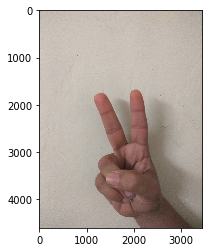

In [17]:
img_path = 'Downloads/two.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation